[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  4 of 4 completed
NaN in data! Fixed.
[[0.14726591 0.00740369 0.28348061 0.90560406]
 [0.14726591 0.00740369 0.28348061 0.90560406]
 [0.16287018 0.00718103 0.28348061 0.93958657]
 ...
 [0.77007934 0.87085282 0.16723317 0.74721776]
 [0.76770556 0.87096412 0.16723317 0.75616054]
 [0.76770556 0.87096412 0.17036029 0.75616054]]


array([[0.13296747, 0.13296747, 0.12935341, ..., 0.14044801, 0.13813977,
        0.13813977],
       [0.13296747, 0.12935341, 0.12935341, ..., 0.13813977, 0.13813977,
        0.1389286 ],
       [0.12935341, 0.12935341, 0.134033  , ..., 0.13813977, 0.1389286 ,
        0.1389286 ],
       ...,
       [0.79062285, 0.79780486, 0.79780486, ..., 0.75404546, 0.75404546,
        0.77007934],
       [0.79780486, 0.79780486, 0.79073449, ..., 0.75404546, 0.77007934,
        0.77007934],
       [0.79780486, 0.79073449, 0.79073449, ..., 0.77007934, 0.77007934,
        0.76770556]])

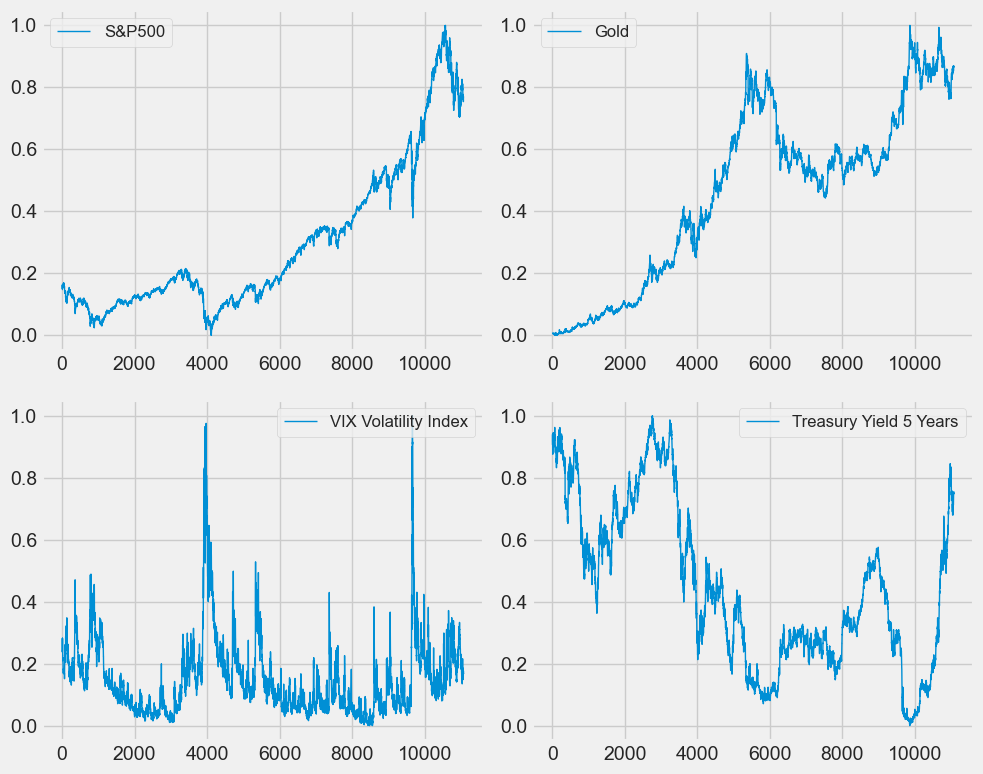

In [1]:
import sys
sys.path.insert(1, r"C:/Users/mihao/OneDrive - Univerza v Ljubljani/Doktorski_studij/Delo/Evolving transformer")
sys.path.insert(1, r"C:\Users\Miha\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\Evolving transformer")
from importlib import reload 
import data.dataclass_module as dataclass_module
reload(dataclass_module)

input_length = 150
output_length = 30
output_steps_ahead = 1
database = dataclass_module.StockData(input_length,output_length,output_steps_ahead)
database.display_data_norm()

#print(database.data_dropped)
print(database.data_norm)

#print(database.datasnp_dropped)
scalar = database.scalar

database.dataset_input
database.dataset_output


In [2]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader




'''
class Stockdataset(Dataset):
    def __init__(self, data, input_length, output_length = 1):
        self.data = data
        self.data = torch.from_numpy(data).float()#.view(-1)
        self.seq_len = input_length
        self.out_len = output_length

    def __len__(self):
        return len(self.data)-(self.seq_len+self.out_len+1)

    def __getitem__(self, index):
        return self.data[index : index+self.seq_len], self.data[index+self.seq_len+1: index+self.seq_len+self.out_len+1,0]
'''
     
size_training = int(len(database.data_norm)*0.70)
size_test = len(database.data_norm) - size_training
data_train, data_test = database.data_norm[0:size_training,:], database.data_norm[size_training:len(database.data_norm),:]

print(data_train.shape)
print(data_test.shape)

train_dataset = dataclass_module.Stockdataset(data_train, input_length, output_length)
test_dataset = dataclass_module.Stockdataset(data_test, input_length, output_length)
whole_dataset = dataclass_module.Stockdataset(database.data_norm, input_length, output_length)

print(test_dataset.__getitem__(1)[0].shape)
print(train_dataset.__getitem__(1)[0].shape)
print(whole_dataset.__getitem__(0)[0].shape)

training_batch_size = 513; #513
batch_size = training_batch_size
train_dataloader = DataLoader(train_dataset, batch_size, drop_last = True, shuffle=True) #drop_last = True ignores last batch is data is not divisable by batch_size
test_dataloader = DataLoader(test_dataset, batch_size, drop_last = True, shuffle=True)
whole_dataloader = DataLoader(whole_dataset, batch_size, drop_last = True, shuffle=False)
#whole_dataloader = DataLoader(train_dataset, 1, drop_last = False)

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the current selected device
    device = torch.device('cuda')

    # Calculate memory details (in bytes)
    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    available_memory = total_memory - allocated_memory

    # Convert bytes to GB
    total_memory_GB = total_memory / (1024 ** 3)
    allocated_memory_GB = allocated_memory / (1024 ** 3)
    available_memory_GB = available_memory / (1024 ** 3)

    print(f"Total memory on GPU: {total_memory_GB} GB")
    print(f"Allocated memory on GPU: {allocated_memory_GB} GB")
    print(f"Available memory on GPU: {available_memory_GB} GB")

    # If available memory is less than 2GB, use CPU
    if available_memory_GB < 1:
        device = torch.device('cpu')

else:
    # If CUDA is not available, use CPU
    device = torch.device('cpu')

print(f"Using device: {device}")



(7751, 4)
(3322, 4)
torch.Size([150, 4])
torch.Size([150, 4])
torch.Size([150, 4])
Total memory on GPU: 5.99957275390625 GB
Allocated memory on GPU: 0.0 GB
Available memory on GPU: 5.99957275390625 GB
Using device: cuda


In [38]:
class LSTMSeq2SeqForecastingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1, dropout_rate=0.1):
        super(LSTMSeq2SeqForecastingNetwork, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        
        # Output layer
        self.fc_out = nn.Linear(hidden_dim, output_dim)

        # Define the dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Define the layer normalization
        self.ln = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        # Apply layer normalization
        lstm_out = self.ln(lstm_out)
        
        # Output layer
        y = self.fc_out(lstm_out)

        return y[:, -output_length:]


In [39]:
import torch.optim as optim

# Hyperparameters
input_dim = 4
output_length = output_length
hidden_dim = 128
num_layers = 3
dropout_rate = 0.1
num_epochs = 10000

model = LSTMSeq2SeqForecastingNetwork(input_dim, hidden_dim, num_layers, 1, dropout_rate).to(device)
learning_rate = 0.001  # or any other value
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

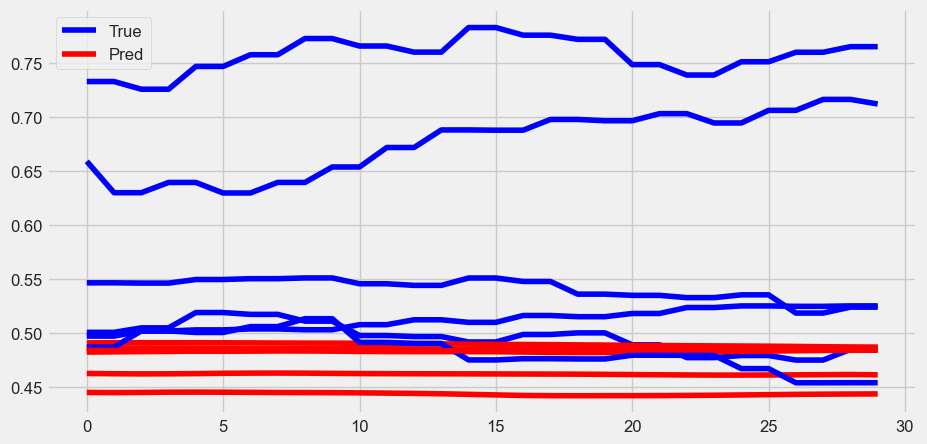

Test Loss: 0.0590
MAE: 0.1060, MSE: 0.0249, RMSE: 0.1579, NRMSE: 1.5203


In [40]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import mean_absolute_error, mean_squared_error

def test(dataloader):
    model.eval()
    test_loss = 0
    all_y = []
    all_out = []
    
    # Close all previous figures
    clear_output(wait=True)

    # Create a new figure
    plt.figure(figsize=(10, 5))

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            test_loss += loss_fn(out, y.unsqueeze(2)).item()

            # For visualization, just take the first sequence in the batch
            y = y[0].cpu().numpy()
            out = out[0].cpu().numpy()

            # Plot the true and predicted sequences with specified colors
            plt.plot(range(len(y)), y, color='blue', label='True' if i == 0 else "")
            plt.plot(range(len(out)), out, color='red', label='Pred' if i == 0 else "")

            # Append the data for MAE, RMSE, MSE, and NRMSE computation
            all_y.append(y)
            all_out.append(out)

    # Show the legend and the plot
    plt.legend()
    plt.show()

    test_loss /= len(dataloader)
    print(f'Test Loss: {test_loss:.4f}')

    # Compute and print MAE, RMSE, MSE, and NRMSE
    all_y = np.concatenate(all_y)
    all_out = np.concatenate(all_out)

    mae = mean_absolute_error(all_y, all_out)
    mse = mean_squared_error(all_y, all_out)
    rmse = np.sqrt(mse)
    nrmse = rmse / np.std(all_y)
    print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, NRMSE: {nrmse:.4f}')

test(test_dataloader)


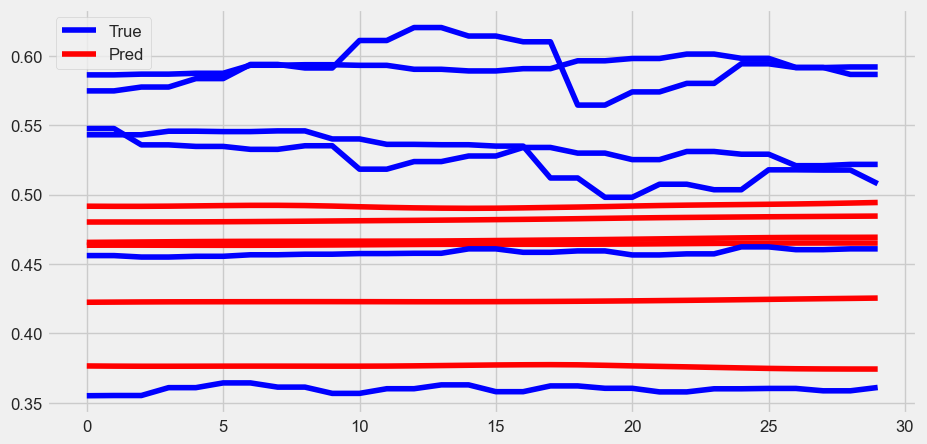

Test Loss: 0.0343
MAE: 0.0644, MSE: 0.0053, RMSE: 0.0731, NRMSE: 0.8960


KeyboardInterrupt: 

In [41]:
# Training
for epoch in range(num_epochs):
    loss_sum = 0
    for batch, (x, y) in enumerate(train_dataloader):
        model.train()

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        
        out = model(x)

        loss = loss_fn(out, y.unsqueeze(2))
        loss.backward()
        
        optimizer.step()
        
        loss_sum += loss.item()

    print(f"Epoch {epoch+1}, training loss: {loss_sum/len(train_dataloader)}")
    if (epoch+1) % 1 == 0:
        loss_test = test(test_dataloader)

# Testing
model.eval()
loss_test = test(test_dataloader)


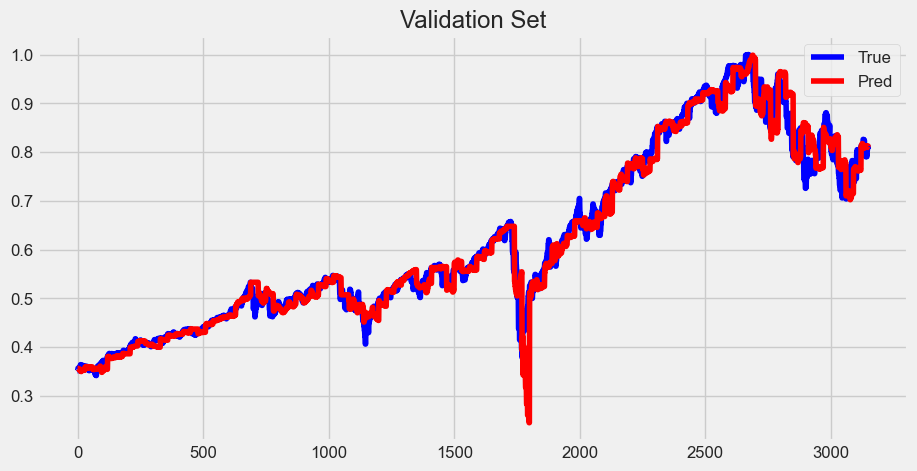

Validation Set - MAE: 0.0186, MSE: 0.0009, RMSE: 0.0304, NRMSE: 0.0461


In [14]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

from IPython.display import clear_output

# Specify the order (p, d, q) of the ARIMA model
order = (30,1,0)

# Split the data into training and validation sets
size_training = int(len(database.data_norm)*0.70)
size_test = len(database.data_norm) - size_training
data_train, data_val = database.data_norm[0:size_training,0], database.data_norm[size_training:len(database.data_norm),0]

input_length = 150
output_length = 30

def predict_and_evaluate(data, dataset_name):
    predictions = []
    actuals = []
    plt.figure(figsize=(10, 5))

    for t in range(input_length, len(data) - output_length, output_length):
        # Create the input sequence
        input_seq = data[t-input_length:t]

        # Define the ARIMA model and fit it to the input sequence
        model = ARIMA(input_seq, order=order)
        model_fit = model.fit()

        # Make output_length-step-ahead forecasts
        forecast = model_fit.forecast(steps=output_length)

        # Store the forecasts
        predictions.extend(forecast)
        actuals.extend(data[t:t+output_length])


    # Clear the current figure's content
    plt.clf()
    clear_output(wait=True)
    # Plot the true and predicted sequences
    plt.plot(range(len(actuals)), actuals, color='blue', label='True')
    plt.plot(range(len(predictions)), predictions, color='red', label='Pred')

    # Legend and title
    plt.legend()
    plt.title(dataset_name)
    plt.show()
    
    # Display the updated plot
    plt.pause(0.01)


    # Compute and print MAE, MSE, RMSE, and NRMSE
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    nrmse = rmse / (max(actuals) - min(actuals))
    print(f'{dataset_name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, NRMSE: {nrmse:.4f}')

predict_and_evaluate(data_train, 'Training Set')
predict_and_evaluate(data_val, 'Validation Set')